In [1]:
from typing import List, Tuple, Any, Dict, Optional
from copy import deepcopy
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.utils.class_weight import compute_class_weight

import torch
import torchvision
import torchvision.models as torch_models
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False

# def init_seed():
#     torch.manual_seed(4321)

NVIDIA GeForce RTX 3080


## Prepare Dataset

In [2]:
class RetinopathyDataset(Dataset):
    _image_root_dir: str
    _image_names: np.ndarray
    _labels: np.ndarray
    _transforms: transforms.Compose

    def __init__(
        self, image_root_dir: str, image_csv: str, label_csv: str, transformation: bool = True, training: bool = True
    ):
        super(RetinopathyDataset, self).__init__()
        if not os.path.exists(image_csv):
            raise FileNotFoundError(f"The csv file {image_csv} does not exist.")
        if not os.path.exists(label_csv):
            raise FileNotFoundError(f"The csv file {label_csv} does not exist.")
        if not os.path.exists(image_root_dir):
            raise FileNotFoundError(f"The folder {image_root_dir} does not exist.")

        self._image_root_dir = image_root_dir
        self._image_names = np.squeeze(pd.read_csv(image_csv).values)
        self._labels = np.squeeze(pd.read_csv(label_csv).values)
        print("> Found %d images..." % (len(self._image_names)))

        transform_operations = [
            transforms.Resize((224, 224))
        ]
        if transformation:
            if training:
                transform_operations += [
                    transforms.RandomInvert(p=0.5),
                    # transforms.RandomChoice([
                    #     transforms.RandomHorizontalFlip(p=0.5),
                    #     transforms.RandomVerticalFlip(p=0.5),
                    #     # transforms.RandomRotation(45, transforms.InterpolationMode.BILINEAR)
                    # ]),
                    # transforms.RandomChoice([
                    #     transforms.RandomInvert(p=0.5),
                    #     transforms.RandomOrder([
                    #         transforms.RandomAutocontrast(p=0.5),
                    #         transforms.RandomEqualize(p=0.5)
                    #     ])
                    # ])
                ]

            transform_operations += [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                # transforms.Normalize(mean=[0.3749, 0.2602, 0.1857], std=[0.2905, 0.2098, 0.1695])
            ]
        else:
            transform_operations = [transforms.ToTensor()]
        self._transforms = transforms.Compose(transform_operations)

    def __len__(self):
        return self._image_names.shape[0]

    def __getitem__(self, index: int):
        """something you should implement here
            step1. Get the image path from 'self.img_name' and load it.
                hint : path = root + self.img_name[index] + '.jpeg'

            step2. Get the ground truth label from self.label

            step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 

                In the testing phase, if you have a normalization process during the training phase, you only need 
                to normalize the data. 

                hints : Convert the pixel value to [0, 1]
                        Transpose the image shape from [H, W, C] to [C, H, W]

            step4. Return processed image and label
        """
        path = self._image_root_dir + "/" + self._image_names[index] + ".jpeg"
        image = self._transforms(Image.open(path))
        return image, self._labels[index]

train_dataset = RetinopathyDataset(image_root_dir = "data", image_csv = "train_img.csv", label_csv = "train_label.csv")
test_dataset = RetinopathyDataset(image_root_dir = "data", image_csv = "test_img.csv", label_csv = "test_label.csv", training = False)

> Found 28099 images...
> Found 7025 images...


## Build Models

In [3]:
class ResNet18(nn.Module):
    model: nn.Module
    def __init__(self, out_features, pretrained = True, feature_extracting = False):
        super(ResNet18, self).__init__()

        self.model = torch_models.resnet18(weights = torch_models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        # freeze pretrained layers
        if pretrained and feature_extracting:
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, out_features)

    def forward(self, x):
        return self.model(x)

class ResNet50(nn.Module):
    model: nn.Module
    def __init__(self, out_features, pretrained = True, feature_extracting = False):
        super(ResNet50, self).__init__()

        self.model = torch_models.resnet50(weights = torch_models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        # freeze pretrained layers
        if pretrained and feature_extracting:
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, out_features)

    def forward(self, x):
        return self.model(x)

## Training & Testing

In [4]:
class Trainer:
    _device: str
    _criterion: nn.Module
    _train_dataloader: DataLoader
    _test_dataloader: DataLoader

    _models_metrics: Dict[str, Dict[str, Any]]

    def __init__(
        self, train_dataloader: DataLoader, test_dataloader: DataLoader, criterion, class_weights: Optional[torch.Tensor] = None
    ):
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        if class_weights is not None:
            class_weights = class_weights.to(self._device)
        self._criterion = criterion(class_weights)
        self._train_dataloader = train_dataloader
        self._test_dataloader = test_dataloader

        self._models_metrics = {}

    @staticmethod
    def _calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
        return torch.sum(torch.argmax(y_pred, dim = 1) == y_true, dtype = torch.int).item()

    def _show_loss(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["loss_history"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title("Loss comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        for name, loss_history in accuracy_histories.items():
            train_loss_list = loss_history["train"]
            test_loss_list = loss_history["test"]
            plt.plot(epochs, train_loss_list, label = f"{name}_train")
            plt.plot(epochs, test_loss_list, label = f"{name}_test")
        plt.legend()
        plt.show()

    def _show_accuracy(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["accuracy_history"] for name, metrics in self._models_metrics.items()}
        best_test_accuracy_dict = {name: metrics["best_test_accuracy"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title("Accuracy comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy(%)")
        for name, accuracy_history in accuracy_histories.items():
            train_accuracy_list = accuracy_history["train"]
            test_accuracy_list = accuracy_history["test"]
            plt.plot(epochs, np.array(train_accuracy_list) * 100, label = f"{name}_train")
            plt.plot(epochs, np.array(test_accuracy_list) * 100, label = f"{name}_test")
        plt.legend()
        plt.show()

        for name, accuracy in best_test_accuracy_dict.items():
            print(f"{name}'s best accuracy: {accuracy}")

    def _save_weights(self, folder_path: str):
        for name, metrics in self._models_metrics.items():
            weights = metrics["best_model_weights"]
            epoch = metrics["best_epoch"]
            torch.save(weights, folder_path + "/" + f"{name}_epoch_{epoch}.pth")

    def _add_metrics(self, models: Dict[str, nn.Module]):
        for name, model in models.items():
            tmp = {
                "accuracy_history": {
                    "train": [],
                    "test": []
                },
                "loss_history": {
                    "train": [],
                    "test": []
                },
                "best_epoch": -1,
                "best_test_accuracy": 0,
                "best_model_weights": None
            }
            self._models_metrics[name] = tmp

    def clear_metrics(self, model_name: str):
        del self._models_metrics[model_name]

    @torch.no_grad()
    def _test(self, epoch: int, model_name: str, model: nn.Module):
        model_metrics = self._models_metrics[model_name]
        loss = 0
        accuracy = 0
        sample_size = len(self._test_dataloader.dataset)

        model.eval()
        for x, y in self._test_dataloader:
            x, y = x.to(self._device), y.to(self._device)
            y_pred = model(x)

            loss += self._criterion(y_pred, y).item() * x.size(0)
            accuracy += self._calculate_accuracy(y_pred, y)

        loss /= sample_size
        accuracy /= sample_size
        model_metrics["loss_history"]["test"].append(loss)
        model_metrics["accuracy_history"]["test"].append(accuracy)
        if accuracy > model_metrics["best_test_accuracy"]:
            model_metrics["best_epoch"] = epoch
            model_metrics["best_model_weights"] = deepcopy(model.state_dict())
            model_metrics["best_test_accuracy"] = accuracy
        return loss, accuracy

    def train(self, models: Dict[str, nn.Module], optimizer_fn, epoch_size: int, early_stop: bool = False, save_weights: bool = False, folder_path: str = "."):
        self._add_metrics(models)
        for name, model in models.items():
            print(f"Training {name} model...")
            model.to(self._device)
            optimizer = optimizer_fn(model.parameters())

            loss_list = []
            accuracy_list = []
            sample_size = len(self._train_dataloader.dataset)
            model_metrics = self._models_metrics[name]

            model.train()
            for epoch in range(1, epoch_size + 1):
                train_loss = 0
                train_accuracy = 0

                for x, y in self._train_dataloader:
                    x, y = x.to(self._device), y.to(self._device)

                    # predict
                    y_pred = model(x)
                    loss = self._criterion(y_pred, y)

                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    train_loss += loss.item() * x.size(0)
                    train_accuracy += self._calculate_accuracy(y_pred.detach(), y.detach())

                test_loss, test_accuracy = self._test(epoch, name, model)

                train_loss /= sample_size
                train_accuracy /= sample_size
                print(f"epoch: {epoch}, train loss: {train_loss}, train accuracy: {train_accuracy}, test loss: {test_loss}, test accuracy: {test_accuracy}")

                loss_list.append(train_loss)
                accuracy_list.append(train_accuracy)

            model_metrics["loss_history"]["train"] = loss_list
            model_metrics["accuracy_history"]["train"] = accuracy_list
            models[name] = model.cpu()
            torch.cuda.empty_cache()

        self._show_loss(epoch_size)
        self._show_accuracy(epoch_size)
        if save_weights:
            print("Saving the weights of the model...")
            self._save_weights(folder_path)
            print("Saved!")
        torch.cuda.empty_cache()

**transforms board**

baseline 77.9

Without normalization
1. random choice (flips), invert (77.4)
2. random choice (flips, rotation), invert (77.6)
3. random choice (invert, equal), random choice (flips) (77.8)
4. invert, random choice (flips, rotation) (77.4) x
5. resize, random choice (flips, rotation), invert (77.5)
6. resize, invert (77.4)
7. resize, invert, brightness 0.1-1.0 (76.9)
8. resize, random choice (invert, equal) (77.7)
9. resize, random choice (invert, equal), RandomAutocontras (77.4)
10. resize, random choice (invert, RandomOrder(equal, RandomAutocontrast)) (77.5)
11. resize, random choice (invert, RandomOrder(equal, RandomAdjustSharpness))
12. resize, random choice (flips, rotation), invert, gaussian blur

Training ResNet18_pretrained model...
epoch: 1, train loss: 0.8250079001093713, train accuracy: 0.7299903911171216, test loss: 0.7391608722863249, test accuracy: 0.7469039145907473
epoch: 2, train loss: 0.7543022370689717, train accuracy: 0.7466457881063383, test loss: 0.7725862519002894, test accuracy: 0.7413523131672598
epoch: 3, train loss: 0.7054522691865363, train accuracy: 0.7614505854300865, test loss: 0.7012541042612965, test accuracy: 0.7634163701067616
epoch: 4, train loss: 0.6762893819512835, train accuracy: 0.7706324068472188, test loss: 0.6834416770256286, test accuracy: 0.7691103202846975
epoch: 5, train loss: 0.6549924324278246, train accuracy: 0.7768603864906224, test loss: 0.6792904110905115, test accuracy: 0.772526690391459
epoch: 6, train loss: 0.6272897151654426, train accuracy: 0.7850813196199153, test loss: 0.6501297485276898, test accuracy: 0.7800711743772242
epoch: 7, train loss: 0.6053468305901949, train accuracy: 0.7921278337307377, test loss: 0.65547252088254

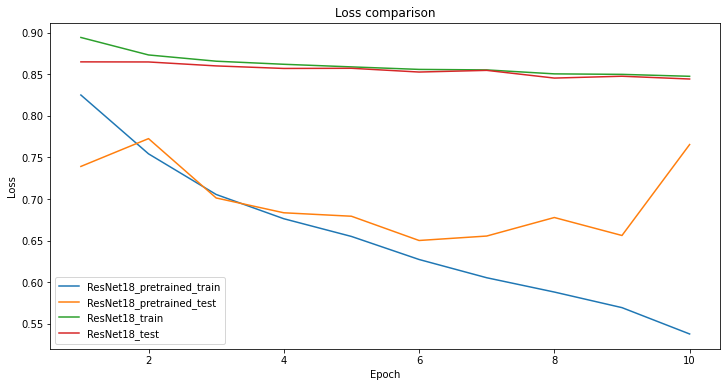

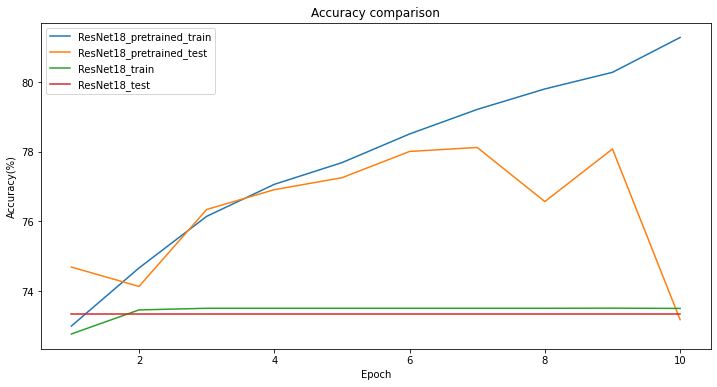

ResNet18_pretrained's best accuracy: 0.7812099644128114
ResNet18's best accuracy: 0.7335231316725979
Saving the weights of the model...
Saved!


In [5]:
BATCH_SIZE: int = 128
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# Prepare models
NUM_CLASSES: int = 5
models = {
    "ResNet18_pretrained": ResNet18(NUM_CLASSES, pretrained = True, feature_extracting = False),
    "ResNet18": ResNet18(NUM_CLASSES, pretrained = False)
}

LEARNING_RATE: float = 1e-3
optimizer_fn = lambda params: torch.optim.SGD(params, lr = LEARNING_RATE, momentum = 0.9, weight_decay = 5e-4)
# weights = torch.tensor(compute_class_weight("balanced", classes = np.unique(train_dataset._labels), y = train_dataset._labels), dtype=torch.float)

EPOCH_SIZE: int = 10
ResNet18_trainer = Trainer(train_dataloader, test_dataloader, nn.CrossEntropyLoss)
ResNet18_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = True, folder_path = "models/baseline")

Training ResNet50_pretrained model...
epoch: 1, train loss: 0.7837501342219005, train accuracy: 0.741165166020143, test loss: 0.7255045468187841, test accuracy: 0.7555871886120996
epoch: 2, train loss: 0.7373247421306666, train accuracy: 0.7526246485640058, test loss: 0.7229416681863235, test accuracy: 0.7553024911032028
epoch: 3, train loss: 0.6821429513392446, train accuracy: 0.7708103491227446, test loss: 0.6876910111318704, test accuracy: 0.7738078291814947
epoch: 4, train loss: 0.6536706713320221, train accuracy: 0.7805259973664543, test loss: 0.6808270084221593, test accuracy: 0.7745195729537366
epoch: 5, train loss: 0.644422827125372, train accuracy: 0.782412185487028, test loss: 0.7301330473329674, test accuracy: 0.7723843416370106
Training ResNet50 model...
epoch: 1, train loss: 0.9251609196666806, train accuracy: 0.7301327449375422, test loss: 1.932900303844031, test accuracy: 0.1597153024911032
epoch: 2, train loss: 0.8979888546720952, train accuracy: 0.7323748176091676, tes

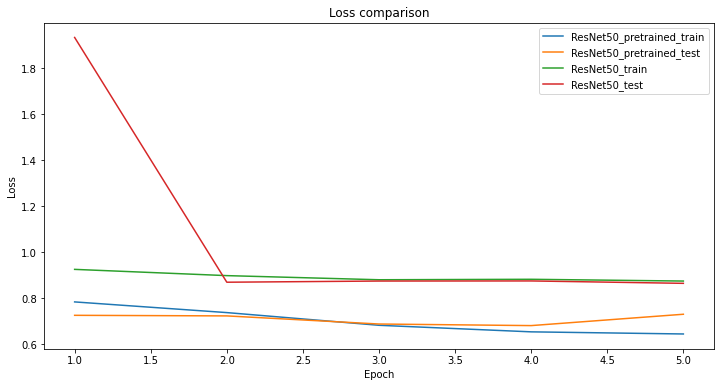

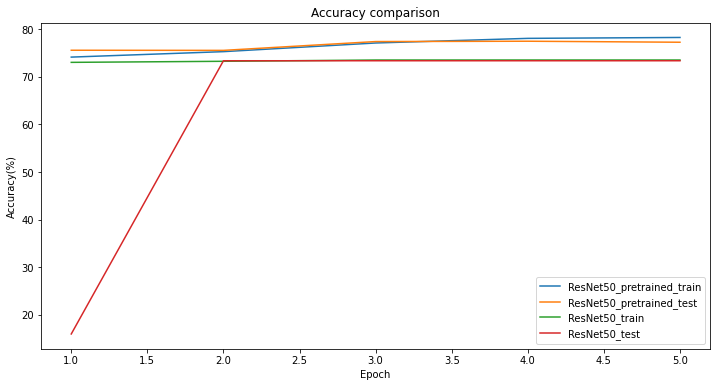

ResNet50_pretrained's best accuracy: 0.7745195729537366
ResNet50's best accuracy: 0.7335231316725979
Saving the weights of the model...
Saved!


In [5]:
BATCH_SIZE: int = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES: int = 5
models = {
    "ResNet50_pretrained": ResNet50(NUM_CLASSES, pretrained = True, feature_extracting = False),
    "ResNet50": ResNet50(NUM_CLASSES, pretrained = False),
}

LEARNING_RATE: float = 1e-3
optimizer_fn = lambda params: torch.optim.SGD(params, lr = LEARNING_RATE, momentum = 0.9, weight_decay = 5e-4)

EPOCH_SIZE: int = 5
ResNet50_trainer = Trainer(train_dataloader, test_dataloader, nn.CrossEntropyLoss)
ResNet50_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = True, folder_path = "models/resnet50")

In [5]:
@torch.no_grad()
def test(model: nn.Module, data_loader: DataLoader):
    predictions = np.array([])
    accuracy = 0
    sample_size = len(data_loader.dataset)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x).detach()

        predictions = np.append(predictions, torch.argmax(y_pred, dim = 1).cpu().numpy())
        accuracy += Trainer._calculate_accuracy(y_pred, y)

    accuracy /= sample_size
    return accuracy, predictions

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

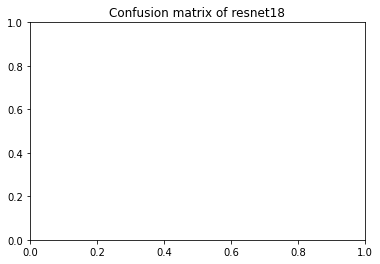

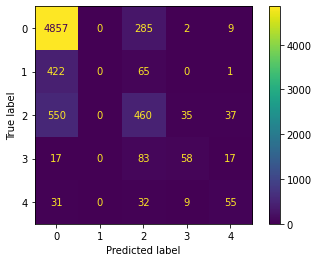

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

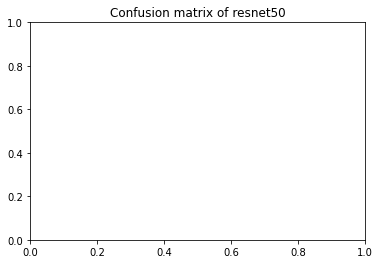

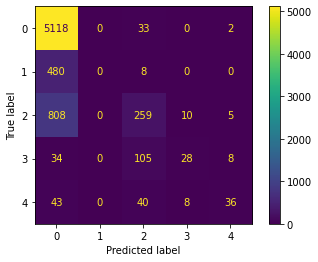

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

BATCH_SIZE: int = 128
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

resnet18 = ResNet18(5, pretrained = False)
resnet18.load_state_dict(torch.load("models/resnet18/ResNet18_pretrained_epoch_10.pth"))
print(resnet18)
acc, preds = test(resnet18, test_dataloader)
print(f"Accuracy of ResNet18:", acc)

labels, _ = np.unique(test_dataset._labels, return_counts = True)
plt.figure()
plt.title("Confusion matrix of resnet18")
ConfusionMatrixDisplay.from_predictions(test_dataset._labels, preds, labels = labels)
plt.show()

resnet50 = ResNet50(5, pretrained = False)
resnet50.load_state_dict(torch.load("models/resnet50/ResNet50_pretrained_epoch_4.pth"))
print(resnet50)
acc, preds = test(resnet50, test_dataloader)
print(f"Accuracy of ResNet50:", acc)
plt.figure()
plt.title("Confusion matrix of resnet50")
ConfusionMatrixDisplay.from_predictions(test_dataset._labels, preds, labels = labels)
plt.show()

In [11]:
THRESHOLD = 0.25

def count_dark_images(dataset: RetinopathyDataset):
    counter = 0
    for name in dataset._image_names:
        img = cv2.imread(f"data/{name}.jpeg")
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        H, L, S = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
        L = L / np.max(L)

        tmp = np.mean(L)
        if tmp < THRESHOLD:
            counter += 1
    return counter / len(dataset)
print("Number of dark images in training data:", count_dark_images(train_dataset))
print("Number of dark images in testing data:", count_dark_images(test_dataset))

Number of dark images in training data: 0.15829744830776896
Number of dark images in testing data: 0.16298932384341638


In [ ]:
N_CHANNELS = 3

dataloader = DataLoader(RetinopathyDataset("data", "train_img.csv", "train_label.csv", transformation = False), batch_size = 512)
number_of_pixels = len(dataloader.dataset) * 512 * 512

mean = torch.zeros(N_CHANNELS)
std = torch.zeros(N_CHANNELS)
print('==> Computing mean..')
for image, _ in dataloader:
    mean += torch.sum(image, dim = (0, 2, 3))
mean = mean / number_of_pixels

expanded_mean = torch.unsqueeze(mean, dim = 1)
print('==> Computing std..')
for image, _ in dataloader:
    tmp = image.transpose(0, 1).flatten(start_dim = 1)
    std += torch.sum((tmp - expanded_mean) ** 2, dim = 1)
std = torch.sqrt(std / number_of_pixels)
print("mean:", mean, "std:", std)